In [16]:
from discord.ext import commands
import discord
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime
from io import BytesIO
from flask import Flask, request
from threading import Thread
import json, os, sys, re
import pandas as pd
from thongke import generate_chart_pay_by_month, generate_chart_debt

scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]


# sử dụng local
creds = ServiceAccountCredentials.from_json_keyfile_name(
    "credentials.json", scope)
client_gs = gspread.authorize(creds)
sheet = client_gs.open("chi_tieu_on_dinh").sheet1

data = sheet.get_all_values()



,NGÀY,HẠNG MỤC CHI,TIỀN,NGƯỜI CHI,NGƯỜI NHẬN,GHI CHÚ
0,2025-01-05,cơm tối,90000.0,Nghĩa,Phương Ngân,
1,2025-02-05,cơm tối,84000.0,Nghĩa,Mọi Người,
2,2025-03-05,cơm tối,20000.0,Nghĩa,Nhi,
3,2025-04-05,cơm tối,30000.0,Nghĩa,Đạt,
4,2025-05-05,nước suối,1410000.0,Phương,Mọi Người,
5,2025-06-05,phở,70000.0,Nhi,Phương Nghĩa,
6,2025-07-05,trà sữa,39000.0,Nhi,Ngân,
7,2025-08-05,cơm gà,30000.0,Nhi,Phương,
8,2025-09-05,chìa khoá,100000.0,Nhi,Mọi Người,
9,2025-10-05,trà tranh,50000.0,Nhi,Nghĩa Phương,


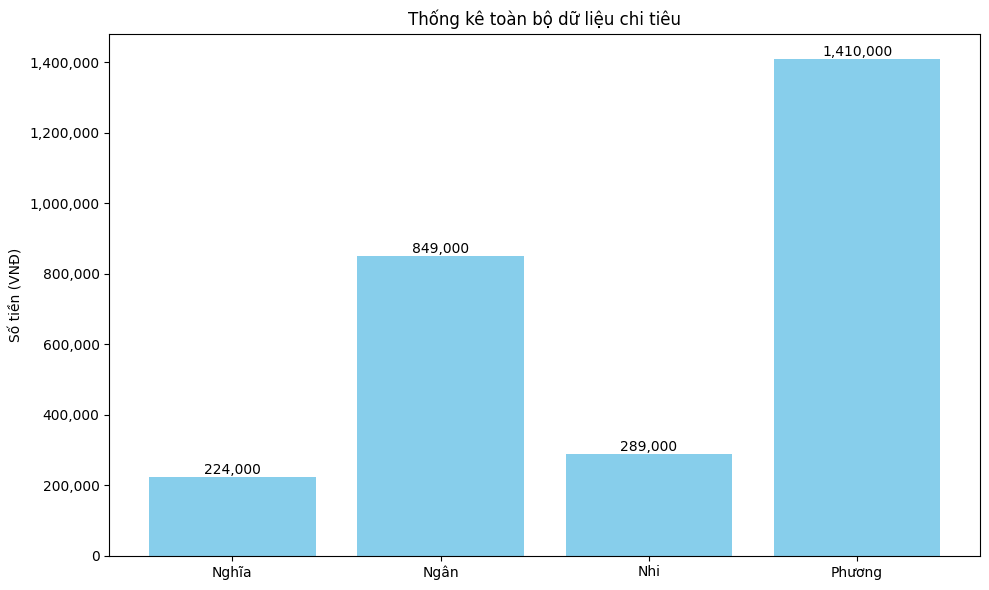

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.DataFrame(data[1:], columns=data[0])

# Làm sạch dữ liệu
df['NGÀY'] = pd.to_datetime(df['NGÀY'], errors='coerce', dayfirst=True)
df['TIỀN'] = df['TIỀN'].str.replace(r'[₫\s]', '',
                                    regex=True).str.replace(',',
                                                            '',
                                                            regex=False)
df['TIỀN'] = pd.to_numeric(df['TIỀN'], errors='coerce')
display(df)
df = df.dropna(subset=['NGÀY'])
time = None
if time:
    try:
        month, year = map(int, time.split('/'))
        if month < 1 or month > 12:
            print("Tháng không hợp lệ. Vui lòng nhập tháng từ 1 đến 12.")
            # return False
        df_filtered = df[(df['NGÀY'].dt.month == month)
                            & (df['NGÀY'].dt.year == year)]
    except Exception as e:
        print(f"Lỗi định dạng thời gian: {e}")
        # return False
else:

    df_filtered = df

# Thống kê
result = df_filtered.groupby('NGƯỜI CHI')['TIỀN'].sum().to_dict()
if not result:
    # return False
    pass

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(result.keys(), result.values(), color='skyblue')

plt.xlabel('')
plt.ylabel('Số tiền (VNĐ)')
try:
    plt.title(f"Thống kê chi tiêu tháng {month}/{year}")
except:
    plt.title("Thống kê toàn bộ dữ liệu chi tiêu")
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x):,}"))

for i, (name, value) in enumerate(result.items()):
    plt.text(i,
                value,
                f"{int(value):,}",
                ha='center',
                va='bottom',
                fontsize=10)

plt.tight_layout()

plt.show()
# buf = BytesIO()
# plt.savefig(buf, format='png')
# buf.seek(0)
# plt.close()

In [18]:
import knowledge
import json
import re

with open("slang_mapping.json", "r", encoding="utf-8") as f:
    slang_mapping = json.load(f)
    slang_mapping = {k.strip().lower(): v for k, v in slang_mapping.items()}


import json
import re

with open("slang_mapping.json", "r", encoding="utf-8") as f:
    slang_mapping = json.load(f)

# Normalize key
slang_mapping = {k.strip().lower(): v for k, v in slang_mapping.items()}

def parse_amount(amount_text, slang_mapping):
    if not amount_text:
        return 0, None

    amt_text = amount_text.lower().replace(",", "").replace(" ", "").strip()
    print(amt_text)
    total_amount = 0

    pattern = r"(\d+(?:\.\d+)?)([a-zA-ZÀ-Ỹà-ỹ]*)"  # thêm support tiếng Việt có dấu
    matches = re.findall(pattern, amt_text)
    print(matches)

    last_unit = None
    for number_part, unit_part in matches:
        try:
            base_amount = float(number_part)
        except:
            base_amount = 0

        unit_part = unit_part.strip().lower()

        if unit_part:
            if unit_part not in slang_mapping:
                return 0, f"❌ Đơn vị `{unit_part}` chưa có trong slang. Vui lòng thêm bằng lệnh `bot ngu: {unit_part} = giá trị`."
            multiplier = slang_mapping[unit_part]
            total_amount += int(base_amount * multiplier)
            last_unit = unit_part
        else:
            if last_unit and last_unit in slang_mapping:
                next_step = slang_mapping[last_unit] / 10
                total_amount += int(base_amount * next_step)
            else:
                total_amount += int(base_amount)

    return total_amount, None

print(parse_amount('2tr', slang_mapping))

2tr
[('2', 'tr')]
(2000000, None)


In [20]:
def replace_slang(text, mapping):
    for slang, real_name in mapping.items():
        text = text.replace(slang, str(real_name))
    return text

text = 'anh Đạt, nợ cũ, 2tr480k, nghĩa'

content = text.split(",")
content = [c.strip() for c in content]
print(content[0])
a = replace_slang(content[0].lower(), slang_mapping)
print(a)

anh Đạt
Đạt
